# Deployment Trend Analysis

In this notebook, we are going to examine the deployment statistics and trying to find out any trends, discovering any weakness that can cause a rollback, so we can make suggestions to fixing it. Further, we want to propose a machine learning algorithm, so that Kitty can learn and predict the probability of a rollback over time.


## Motivations
All deployment statistics are gathered from JIRA and exported to a CSV file. While the workflow and fields are changed over time, there are columns with NULL value, we will explain how we handle each particular case below. 

By doing simple data analysis, we want to be able to answer questions such as below:
* Did we improve quality over time? Is it due to some process change we made?
* Certain team/developer/type of application has more rollback than the others?
* Is it true that more junior developers are more likely to make mistakes?
* When pushing too much work to a team such that it is over its capacity, is rollback more likely to occur?
* If time since last deployment is too long, developer may not remember to perform certain validation task, is it going to likely cause issues?

## Machine learning
* Kitty will be trained with deployment statistics between Jan 1, 2015 to last month, and use the current month data for model validation
* In the future, when an issue is passed to Kitty for QA approval, it will pass to this machine learning algorithm to determine a number between 0 to 1, which is the likelihood a rollback will occur
* Once the deployment issue is closed, the result (rolled back = Yes/No) is fed back to Kitty so she can continue to learn over time

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import all deployment statistics since 2013
train = pd.read_csv("deployment_stats.csv");
train.head(2)

,ticket,category_id,priority,region,version,contain_pilot,contain_prod,created,reporter,developer,...,verify_required,deploy_instruct,risks,impact,num_pilot_instances,num_prod_instances,pilot_rollback_reason,pilot_rollback_date,prod_rollback_reason,prod_rollback_date
0,AMAN-6,10704,1,AU,NaN,1,1,2014-05-30 14:04:56,gchan,NaN,...,0,NaN,0,0,0,1,NaN,NaN,NaN,NaN
1,AOF-100,10100,1,HK,NaN,1,1,2013-12-04 20:37:52,jng,NaN,...,0,NaN,0,0,0,0,NaN,NaN,NaN,NaN


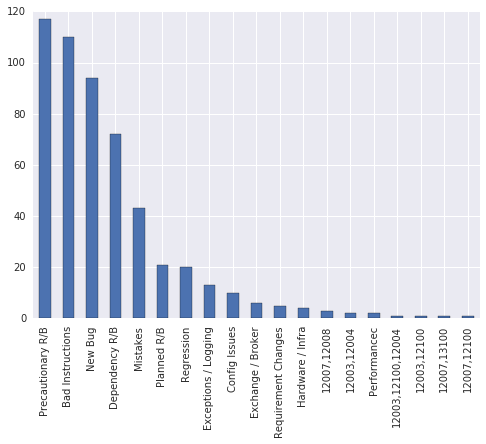

In [31]:
rbr = train["prod_rollback_reason"]                   
rbr.replace('12007', 'Bad Instructions', inplace=True)
rbr.replace('12802', 'Requirement Changes', inplace=True)
rbr.replace('13100', 'Config Issues', inplace=True)
rbr.replace('12101', 'Dependency R/B', inplace=True)
rbr.replace('12008', 'Mistakes', inplace=True)
rbr.replace('12006', 'Exceptions / Logging', inplace=True)
rbr.replace('12727', 'Exchange / Broker', inplace=True)
rbr.replace('12803', 'Hardware / Infra', inplace=True)
rbr.replace('12003', 'New Bug', inplace=True)
rbr.replace('12005', 'Performancec', inplace=True)
rbr.replace('12500', 'Planned R/B', inplace=True)
rbr.replace('12100', 'Precautionary R/B', inplace=True)
rbr.replace('12004', 'Regression', inplace=True)
rbr[1:].value_counts().plot(kind='bar')
plt.show()

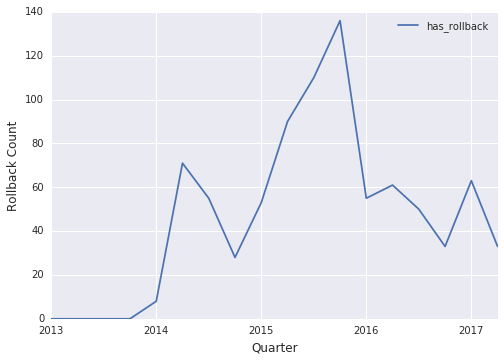

In [32]:
# now take a look whether rollback are concentrated at certain dates
train["has_rollback"] = ~(train["pilot_rollback_reason"].isnull() & train["prod_rollback_reason"].isnull())
train["resolution_q"] = pd.to_datetime(train['resolution_date'], errors='coerce').dt.to_period("Q")
trb = train.pivot_table(index="resolution_q", values=['has_rollback'], aggfunc=np.sum)

plt.figure(figsize=(8,6))
trb.plot(kind='line')
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Rollback Count', fontsize=12)
plt.show();

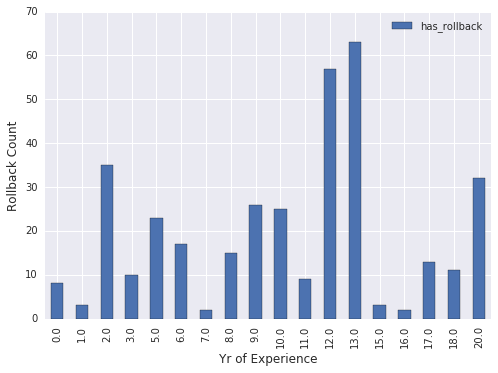

In [33]:
# add intelligence on the number of years in working experience, and plot whether rollback is correlated to this in any way
# fill in developer as reporter if developer is NULL
train["developer"].replace('NULL', 'missing', inplace=True)
train.developer.unique()
year_exp = {"ahui": 13, "jng": 20, "szeng": 1, "elam": 13, "tleung": 12, "hkyeung": 10, "hng": 5,
       "wchan": 9, "ajing": 2, "ttong": 18, "otsang": 0, "mchauhan": 9, "kpang": 9, "jsuen": 0,
       "vpatil": 8, "rbruce": 11, "tlai": 2, "btegarden": 13, "llam": 10, "avale": 0,
       "skecskes": 0, "azhao": 5, "kzhu": 12, "bflynn": 11, "wlu": 6, "szhang": 13, "mleung": 0,
       "vneeraj": 3, "sjain": 8, "myao": 1, "dxu": 1, "bdravid": 12, "mswami": 17, "ljackson": 16,
       "jcheng": 5, "lleung": 13, "hmamdani": 2, "jpeng": 9, "achan": 12, "mchiu": 12,
       "mgoldschmidt": 15, "afacchi": 6, "abeaulne": 5, "pmembrey": 7, "eyang": 2,
       "odeblic": 9, "dchandola": 8, "llaszko": 11, "ahampshire": 13, "jchandran": 10,
       "kaddanki": 2, "syi": 0, "ggriffin": 20}
train["years_exp"] = train["developer"].map(year_exp)

trb_yr = train.pivot_table(index="years_exp", values=['has_rollback'], aggfunc=np.sum)
plt.figure(figsize=(8,6))
trb_yr.plot(kind='bar')
plt.xlabel('Yr of Experience', fontsize=12)
plt.ylabel(' Count', fontsize=12)
plt.show();

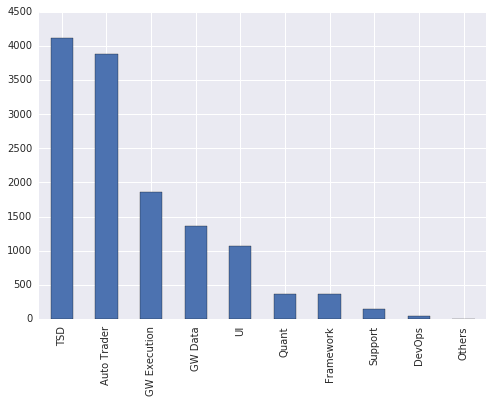

In [34]:
# Breaking down by category & applications
rbc = train["category_id"]
rbc.replace(10100, 'Auto Trader', inplace=True)
rbc.replace(10000, 'Framework', inplace=True)
rbc.replace(10700, 'GW Data', inplace=True)
rbc.replace(10701, 'GW Execution', inplace=True)
rbc.replace(10703, 'Others', inplace=True)
rbc.replace(10300, 'DevOps', inplace=True)
rbc.replace(10002, 'UI', inplace=True)
rbc.replace(10400, 'Quant', inplace=True)
rbc.replace(10800, 'TSD', inplace=True)
rbc.replace(10200, 'Performance', inplace=True)
rbc.replace(10704, 'Support', inplace=True)
rbc.replace(10101, 'Others', inplace=True)
rbc.replace(10003, 'Others', inplace=True)
rbc.replace(10600, 'Others', inplace=True)
rbc[1:].value_counts().plot(kind='bar')
plt.show()

In [75]:
# generate the project key, sort by it
train["project"] = train["ticket"].str.split("-").str[0]
train = train.sort_values(by=['project', 'resolution_date'])

# find out the last deployed date in the same project, find number of days
train["last_deployed"] = train.groupby("project").resolution_date.shift()
#train["time_since_last_deployed"] = pd.to_datetime(train["resolution_date"]) - pd.to_datetime(train["last_deployed"])
train.head(5)


,ticket,category_id,priority,region,version,contain_pilot,contain_prod,created,reporter,developer,...,prod_rollback_reason,prod_rollback_date,has_rollback,resolution_q,years_exp,project,last_deployed,time_since_last_deployed,last_two_weeks,values
0,AMAN-6,Support,1,AU,NaN,1,1,2014-05-30 14:04:56,gchan,gchan,...,NaN,NaN,False,2014Q2,NaN,AMAN,NaT,NaT,NaN,0.0
133,AOF-71,Auto Trader,1,NaN,2.00.0000,0,0,2013-01-21 16:15:10,NaN,NaN,...,NaN,NaN,False,2013Q1,NaN,AOF,NaT,NaT,NaN,0.0
135,AOF-75,Auto Trader,1,NaN,NaN,0,0,2013-02-27 10:05:45,NaN,NaN,...,NaN,NaN,False,2013Q1,NaN,AOF,2013-01-29 14:25:29,29 days 03:03:25,NaN,0.0
136,AOF-77,Auto Trader,1,NaN,2.01.0000,0,0,2013-03-06 18:43:40,NaN,NaN,...,NaN,NaN,False,2013Q1,NaN,AOF,2013-02-27 17:28:54,7 days 16:41:37,NaN,0.0
138,AOF-80,Auto Trader,1,NaN,2.02.0000,0,0,2013-03-21 18:02:49,NaN,NaN,...,NaN,NaN,False,2013Q1,NaN,AOF,2013-03-07 10:10:31,15 days 00:01:06,NaN,0.0


In [74]:
# get number of deployments of the same project in the last 5 days
# This cell is disabled because the current implmentation takes too much CPU to compute

#train["resolution_date"] = pd.to_datetime(train["resolution_date"])
#for index, row in train.iterrows():
#    mask = (train.project == row.project) & (train.resolution_date > (row.resolution_date - pd.Timedelta(days=14))) & (train.resolution_date < row.resolution_date) & (train.has_rollback == True)
#    train.loc[index, 'values'] = sum(mask) # insert to the new column


# Feature Engineering
So far we have done data analysis and data transformation, the following data will be used for deep learning
* project
* dates
* risk scores
* time_since_last_deployed

# Tensorflow
Now that we have generated the following feature, it is about time to do some deep learning.

In this study, we will use this library: xxx
and that we are going to use this model: yyy

In [76]:
import tensorflow as tf